# January 2023 Hackathon Friday Demo

In [124]:
API_IP_ADDR="http://100.26.10.46/"
GPT_KEY=""

In [125]:
import requests, ast

## 1. Annotating code with formulas from the paper

### Conversion

Let's first load the scenario 1 code we will be working with:

In [126]:
with open("seird.py", "r") as f:
        code = f.read()
print(code)

# define SEIRD_model
def SEIRD_model(y, t, N0, alpha, beta, gamma, epsilon, mu):
    S, E, I, R, D, N = y
    dSdt = mu*N -beta * S * I / N0 - mu*S
    dEdt = beta * S * I / N0 - (mu + epsilon) * E
    dIdt = epsilon * E - (gamma + mu + alpha) * I
    dRdt = gamma * I - mu *R
    dDdt = -(dSdt + dEdt + dIdt + dRdt)
    dNdt = -dDdt
    return dSdt, dEdt, dIdt, dRdt, dDdt, dNdt


Here ais a picture of a formula in the model from the text:

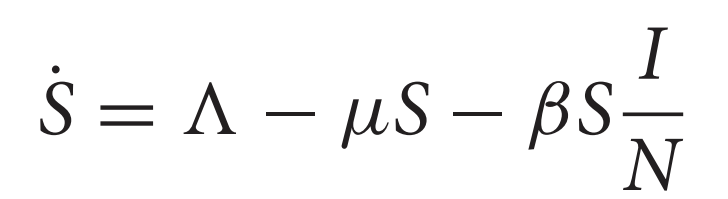

In [127]:
from IPython import display
display.Image("dSdt.png")

Courtesy of the `pix2tex` package, which we are running on the same server as our API, we can obtain LaTeX from these images:

In [132]:
latex_str = !python3 img_latex.py -p dSdt.png
print(latex_str)

['"\\dot{S}=\\Lambda-\\mu S-\\beta S{\\frac{I}{N}}"']


### Annotation

We can then use these formulas to annotate lines from the code using our `code_formula/run` endpoint:

In [131]:
inputs = {"input_code": code, "input_formulas": latex_str, "gpt_key": GPT_KEY}

code_line = requests.post(API_IP_ADDR + "code_formula/run", params=inputs).text
print(code_line)


[["\"\\dot{S}=\\Lambda-\\mu S-\\beta S{\\frac{I}{N}}\"","\n\ndSdt = mu*N -beta * S * I / N0 - mu*S"]]


## 2. Extracting (imperfect) Petri net components from code

In this part of the demo, we show how our API provides calls to extract state variables, parameter variables and transitions of a Petri net, starting with a python function describing the related model.

The python function we saw earlier describes an SEIRD model. If we're interested in representing this model with a Petri net, we can use our API's `petri/get_places` endpoint to first extract the places (states) of the net:

In [114]:
dict= {"code": code, "gpt_key": GPT_KEY}
places = requests.post(API_IP_ADDR + "petri/get_places", params=dict).text
print(places)

["S"," E"," I"," R"," D"," N"]


We can then also extract the parameter variables using the `petri/get_parameters` endpoint:

In [115]:
parameters = requests.post(API_IP_ADDR + "petri/get_parameters", params=dict).text
print(parameters)

["alpha"," beta"," gamma"," epsilon"," mu"]


And we can finally also extract transititions using the `petri/get_transitions` endpoint:

In [116]:
transitions = requests.post(API_IP_ADDR + "petri/get_transitions", params=dict).text
print(transitions)

[["S"," E"],["E"," I"],["I"," R"],["R"," D"],["D"," N"],["N"," S"]]


## 3. Annotating the extracted Petri net places based on the paper text

Let's first load part of the paper to which the code above corresponds

In [12]:
with open("section2.txt", "r") as f:
        text = f.read()
print(text[:500])
print("...")

When no vaccine is available, the isolation of diagnosed infectives and social distancing are the only control measures available. We consider an SEIR epidemic disease model [e.g., (5, 7–9)]. The total (initial) population, N0, is categorized into four classes, namely, susceptible, S(t), exposed, E(t), infected-infectious, I(t) and recovered, R(t), where t is the time variable. The governing differential equations are

S˙=Λ−μS−βSIN,E˙=βSIN−(μ+ϵ)E,I˙=ϵE−(γ+μ+α)I,R˙=γI−μR,    (1)
 
where N = S + E
...


Let's convert the places that we obtained through the `petri/get_places` call above into an actual python list:

In [15]:
places = ast.literal_eval(places)

Now let's use the `petri/match_place_to_text` endpoint to obtain a description for each place from the paper text:

In [17]:
dict2= {"text": text, "gpt_key": GPT_KEY}
for place in places:
        dict2["place"] = place
        desc = requests.post(API_IP_ADDR + "petri/match_place_to_text", params=dict2).text
        print(f"Description for {place}: {desc}\n------\n")

Description for S: "\"The total (initial) population, N0, is categorized into four classes, namely, susceptible, S(t), exposed, E(t), infected-infectious, I(t) and recovered, R(t), where t is the time variable.\""
------

Description for  E: "\"The exposed (E) become infectious (I) with a rate ϵ and the infectious recover (R) with a rate γ.\""
------

Description for  I: "\"The infected-infectious, I(t), class is where people go from S to E depending on the number of contacts with I individuals, multiplied by the probability of infection (β).\""
------

Description for  R: "\"Recovered means an individual who does not flow back into the S class, as lifelong immunity is assumed, but it remains to be seen whether patients recovered from COVID-19 will develop antibodies and achieve lifelong protection.\""
------

Description for  D: "\"The dead population as a function of time is D(t) = N0 − N(t), whereas the curve giving the dead people per unit time is\""
------

Description for  N: "\"

## 4. Finding values for extracted Petri net parameters based on the paper text

Let's load some more of the paper text:

In [18]:
with open("sections34.txt", "r") as f:
        text2 = f.read()
print(text2[:500])
print("...")

We solve the differential Equations (1) by using a forward Euler finite-difference scheme [e.g., (17)], discretizing the time variable as t = ndt, where n is a natural number and dt is the time step. After discretization, Equations (1) and (2) become:

Sn+1=Sn+dt(Λ−μSn−βSnInNn),En+1=En+dt[βSnInNn−(μ+ϵ)En],In+1=In+dt[ϵEn−(γ+μ+α)In],Rn+1=Rn+dt(γIn−μRn),D˙n=−(S˙n+E˙n+I˙n+R˙n)(t),    (7)
 
where Ḋn is the number of dead people in only the specific day n. This algorithm yields positive and bounded so
...


Let's convert the parameters that we obtained through the `petri/get_parameters` call above into an actual python list:

In [22]:
parameters = ast.literal_eval(parameters)

Now let's use the `petri/init_param_from_text` endpoint to obtain an initial value, and the associated units, for each parameter from the paper text:

In [26]:
dict3= {"text": text2, "gpt_key": GPT_KEY}
for param in parameters:
        dict3["param"] = param
        desc = requests.post(API_IP_ADDR + "petri/init_param_from_text", params=dict3).text
        print(f"Initial value for {param}: {desc}\n------\n")


Initial value for alpha: ["0.006","/day"]
------

Initial value for  beta: ["0.75","/day"]
------

Initial value for  gamma: ["(1/8)","/day"]
------

Initial value for  epsilon: ["1/3","/day"]
------

Initial value for  mu: ["0.006","/day"]
------

